<a href="https://colab.research.google.com/github/santhoshmohan8/timeseriesforecast/blob/main/SARIMAX_Forecast_and_Anamoly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**`SARIMAX time series forecast and anamoly detection - Catfish sales`**

Import packages and custom functions

In [1]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# import csv data - catfish sales
def custom_date(date):
  return pd.datetime.strptime(date,"%Y-%m-%d")

def plot_timeseries(raw_data,forecast_data=None,forecast_data2=None):
  plt.figure(figsize=(12,5))
  forecast_data = raw_data if forecast_data is None else forecast_data
  forecast_data2 = raw_data if forecast_data2 is None else forecast_data2
  plt.plot(raw_data)
  plt.plot(forecast_data)
  plt.plot(forecast_data2)
  plt.legend()
  plt.title("Catfish sales actual data")
  plt.xlabel("Date")
  plt.ylabel("Sales")
  startdate, enddate = raw_data.index.min(), raw_data.index.max()
  for yr in range(startdate.year,enddate.year+1):
    plt.axvline(pd.to_datetime(str(yr)+'-03-01'), color='b', alpha=0.1, linestyle="--")

Import csv file and limiting problem dataset for forecast

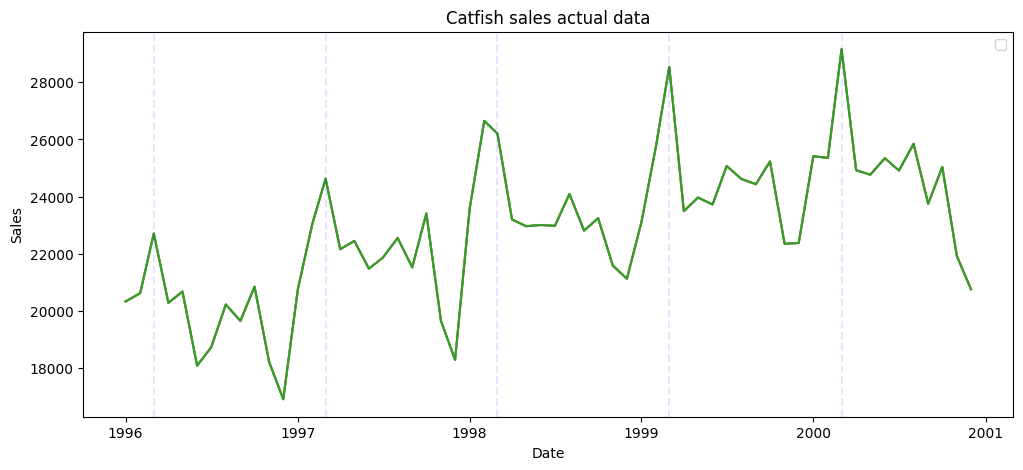

In [2]:
catfish = pd.read_csv('catfish.csv', index_col=0, parse_dates=[0], date_parser = custom_date, squeeze = True)
catfish.head()

# check freq and resampling to monthly freq
catfish = catfish.asfreq(pd.infer_freq(catfish.index))

catfish.index.min()
catfish.index.max()

#limiting problem dataset from 1996 till 2000
startdate = datetime(1996,1,1)
enddate = datetime(2000,12,1)
catfish = catfish[startdate:enddate]
catfish.shape
plot_timeseries(catfish)

Trend check - First difference or higher

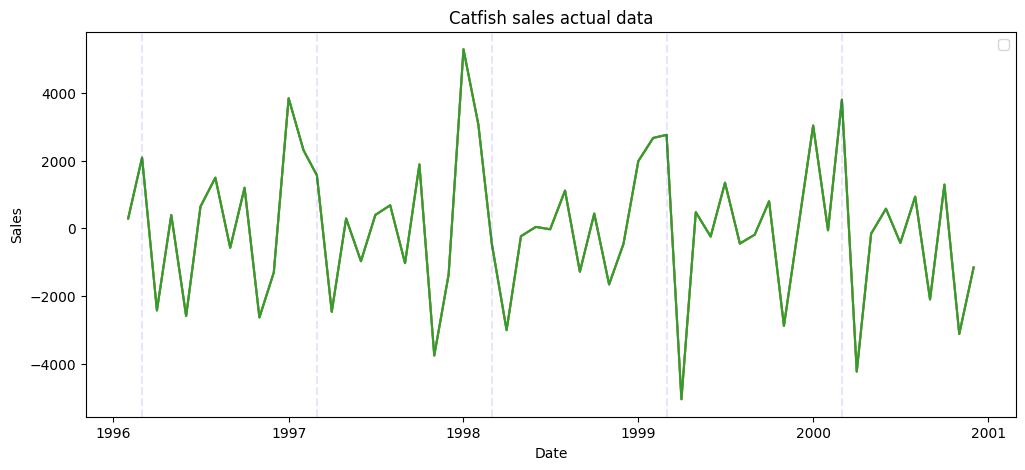

In [3]:
catfish_diff = catfish.diff()[1:]
plot_timeseries(catfish_diff)

# first difference satisfies stationary function

Forecast using SARIMAX model - No anamoly in dataset

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

RMSE: 1365.3218
MAPE: 0.0453
RMSE: 1189.2849
MAPE: 0.0419


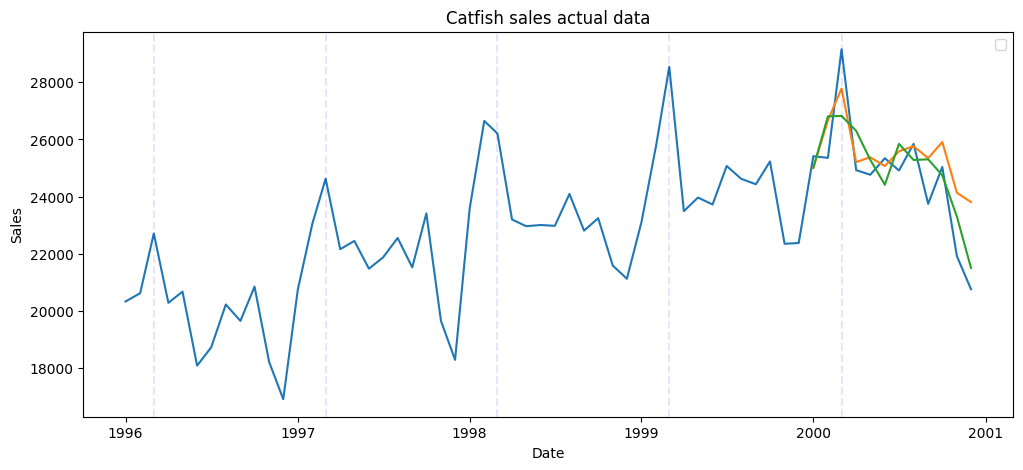

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# forecast mmodel 1 - static predictions
def SARIMAX_1(train,test):
  model = SARIMAX(train, order = (1,1,1), seasonal_order=(1,0,1,12)).fit()
  pred_test = model.get_forecast(steps=12).predicted_mean
  return pred_test

# forecast mmodel 2 - rolling predictions
def SARIMAX_2(train,test):
  rolling_prediction=pd.Series()
  for n in range(test.shape[0]):
    train_new = pd.concat([train,test[:n]],axis=0)
    model=SARIMAX(train_new, order = (1,1,1), seasonal_order=(1,0,1,12)).fit()
    rolling_prediction = rolling_prediction.append(model.forecast())
  return rolling_prediction

# model results - RMSE & MAPE
def model_results(y,y_pred):
  print("RMSE:",round(np.sqrt(np.mean((y - y_pred)**2)),4))
  print("MAPE:",round(np.mean(abs(y - y_pred)/y),4))

# train test split
train_enddate = datetime(1999,12,1)
train = catfish[:train_enddate]
test = catfish[train_enddate + timedelta(days=1):]

pred_data = SARIMAX_1(train,test)
pred_roll = SARIMAX_2(train,test)
model_results(test,pred_data)
model_results(test,pred_roll)

plot_timeseries(catfish,pred_data,pred_roll)

Add anamoly -> Find Anamoly -> Normalize anamoly -> Plot

In [5]:
from sklearn.ensemble import IsolationForest

# Find anamoly
def find_anamoly(dataset,train,test):
  model_IF = IsolationForest(contamination=0.01).fit(train.values.reshape(-1,1))
  train_ana_scores = model_IF.decision_function(train.values.reshape(-1,1))
  test_ana_scores = model_IF.decision_function(test.values.reshape(-1,1))
  pred_anam_train = model_IF.predict(train.values.reshape(-1,1))
  pred_anam_test = model_IF.predict(test.values.reshape(-1,1))
  df_cf = pd.DataFrame(pd.concat([dataset,
                                  pd.Series(np.concatenate((pred_anam_train,pred_anam_test), axis=0), index=dataset.index),
                                  pd.Series(np.concatenate((train_ana_scores,test_ana_scores), axis=0), index=dataset.index)], axis=1))
  df_cf.rename(columns={'Total':'Sales',0:'Flag',1:'Ana_score'}, inplace=True)
  return df_cf

# normalize anamoly
def normalize_anamoly(df_cf):
  norm_df = df_cf.copy()
  anamoly_dates = norm_df[norm_df['Flag'] == -1].index
  for date in anamoly_dates:
    norm_df.loc[date,'Sales'] = norm_df[(norm_df.index.month == date.month) & (norm_df.index != date)].Sales.mean()
  return norm_df


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

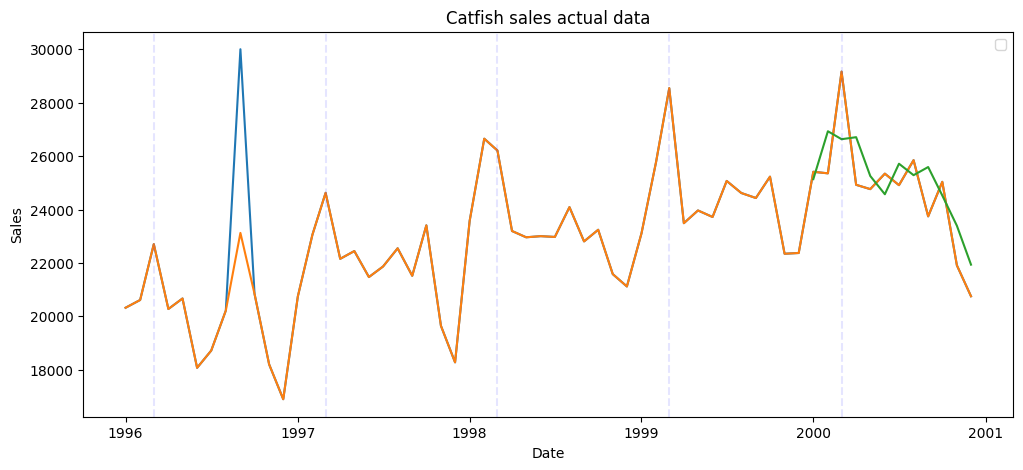

In [7]:
# Add, find, normalize, plot anamoly
catfish[datetime(1996,9,1)] = 30000
df_cf = find_anamoly(catfish,train,test)
norm_df = normalize_anamoly(df_cf)

# forecast timeseries
norm_forecast = norm_df['Sales']
train_enddate = datetime(1999,12,1)
train = norm_forecast[:train_enddate]
test = norm_forecast[train_enddate + timedelta(days=1):]

rolling_prediction = SARIMAX_2(train,test)
plot_timeseries(df_cf['Sales'],norm_df['Sales'],rolling_prediction)